# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-29
COBRApy version: 0.23.0
MASSpy version: 0.1.7


### Set solver

In [2]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [3]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [4]:
medium = "Glucose"
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data",
    index_col=0
)
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data_reduced",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
Rxn,
GLCptspp,9.613287
PGI,5.698950
PFK,7.057500
FBP,0.000000
FBA,7.057500
...,...
L_LACD2,0.000000
CYTBO3_4pp,38.191466
CYTBDpp,0.000000


### Set bounds
#### Growth rate and media

In [5]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0] #This index is hard-coded based on which column has the flux value
biomass_rxn.bounds = (0, growth_rate)
biomass_rxn.bounds

(0, 0.455338783207954)

In [6]:
growth_rate

0.455338783207954

In [7]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0] #This index is hard-coded based on which column has the flux value
EX_glc__D_e.bounds = (medium_uptake, 0)
EX_glc__D_e.bounds

(-9.655, 0)

### Formulate QP minimization for fluxes

In [8]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]

for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
            
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76325
FBP 0.7057500000000001
PYK 2.73493
PPS 0.24863000000000002


,fluxes,reduced_costs
CYTDK2,0.000000,0.0
XPPT,0.000000,0.0
HXPRT,0.000000,0.0
NDPK5,0.000000,0.0
SHK3Dr,0.211771,0.0
...,...,...
MPTS,0.000000,0.0
MOCOS,0.000000,0.0
BMOGDS2,0.000000,0.0
FESD2s,0.000000,0.0


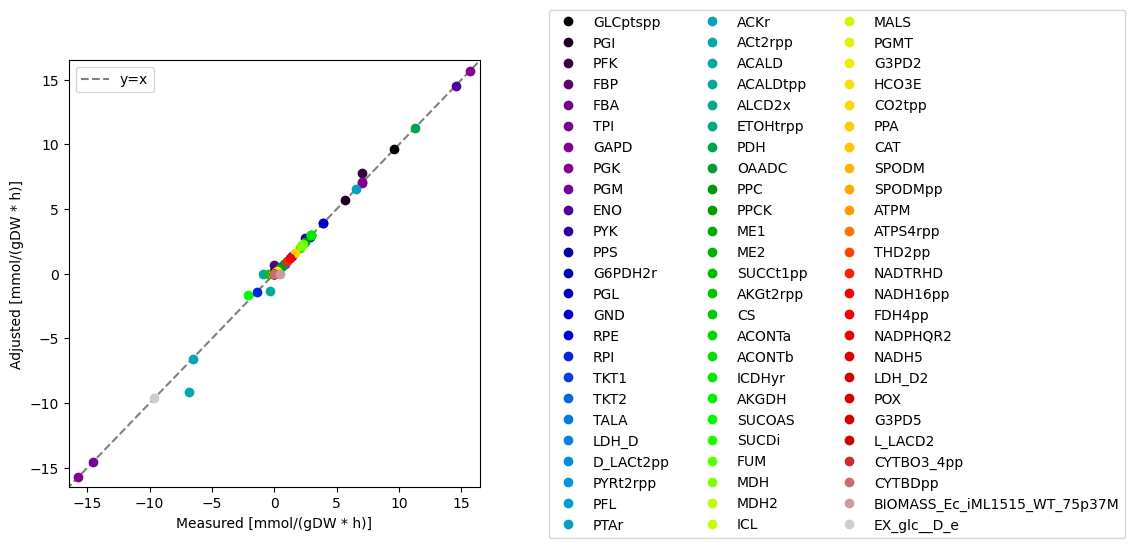

In [9]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [10]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes_extended.csv")

## Create MASS Model

In [11]:
# Create MassModel
mass_model = MassModel("CentralMetabolism", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "GLCptspp",
"PGI",
"PFK",
"FBP",
"FBA",
"TPI",
"GAPD",
"PGK",
"PGM",
"ENO",
"PYK",
"PPS",
"G6PDH2r",
"PGL",
"GND",
"RPE",
"RPI",
"TKT1",
"TKT2",
"TALA",
"LDH_D",
"D_LACt2pp",
"PYRt2rpp",
"PFL",
"PTAr",
"ACKr",
"ACt2rpp",
"ACALD",
"ACALDtpp",
"ALCD2x",
"ETOHtrpp",
"PDH",
"OAADC",
"PPC",
"PPCK",
"ME1",
"ME2",
"SUCCt1pp",
"AKGt2rpp",
"CS",
"ACONTa",
"ACONTb",
"ICDHyr",
"AKGDH",
"SUCOAS",
"SUCDi",
"FUM",
"MDH",
"MDH2",
"ICL",
"MALS",
"PGMT",
"G3PD2",
"HCO3E",
"CO2tpp",
"PPA",
"CAT",
"SPODM",
"SPODMpp",
"ATPM",
"ATPS4rpp",
"THD2pp",
"NADTRHD",
"NADH16pp",
"FDH4pp",
"NADPHQR2",
"NADH5",
"LDH_D2",
"POX",
"G3PD5",
"L_LACD2",
"CYTBO3_4pp",
"CYTBDpp",
]

cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,CentralMetabolism
Memory address,0x01f939b09488
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,0/70
Number of reactions,73
Number of genes,67
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [12]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [13]:
Keq_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

In [14]:
conc_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
10fthf_c,1.051286e-04
13dpg_c,5.507545e-05
23dhb_c,1.380000e-04
2ddg6p_c,1.247644e-05
2dmmql8,1.051286e-04
...,...
utp_c,8.290000e-03
val__L_c,4.020000e-03
xu5p__D_c,6.447318e-04


### Add PFK1 activator GDP

In [15]:
#gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
#gdp_c.fixed = True

#mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [16]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite glc__D_p at 0x1f939b04bc8>, <MassMetabolite 6pgl_c at 0x1f939af7508>, <MassMetabolite lac__D_c at 0x1f939af1d88>, <MassMetabolite h_p at 0x1f939aeff88>, <MassMetabolite lac__D_p at 0x1f939aeff08>, <MassMetabolite pyr_p at 0x1f939aef388>, <MassMetabolite ac_p at 0x1f939aec2c8>, <MassMetabolite acald_c at 0x1f939aec748>, <MassMetabolite acald_p at 0x1f939ae9ec8>, <MassMetabolite etoh_c at 0x1f939ae9d08>, <MassMetabolite etoh_p at 0x1f939ae9148>, <MassMetabolite succ_p at 0x1f939ae1648>, <MassMetabolite akg_p at 0x1f939ae11c8>, <MassMetabolite glx_c at 0x1f939ad3e48>, <MassMetabolite co2_p at 0x1f939ace7c8>, <MassMetabolite h2o2_c at 0x1f939ace488>, <MassMetabolite o2s_c at 0x1f939acedc8>, <MassMetabolite h2o2_p at 0x1f939acaa48>, <MassMetabolite o2_p at 0x1f939aca6c8>, <MassMetabolite o2s_p at 0x1f939aca388>, <MassMetabolite for_p at 0x1f939ac4dc8>, <MassMetabolite lac__L_c at 0x1f939abe848>]


mass\core\mass_model.py:1967 UserWarning: No metabolite found for '10fthf_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '23dhb_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2ddg6p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dmmql8'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dr5p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4abut_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4hbz_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '5mthf'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'aacoa_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acgam1p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acorn_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'ade_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'adn_c'
mass\core\mass_

### Formulate QP minimization for concentrations

In [17]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [18]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
g6p_c,2.242760e-03,0.0
glc__D_p,1.000000e-03,0.0
pep_c,1.714436e-06,0.0
pyr_c,1.186056e-04,0.0
f6p_c,3.346820e-04,0.0
...,...,...
Keq_POX,7.927669e+15,0.0
Keq_G3PD5,3.001950e+06,0.0
Keq_L_LACD2,2.291433e+06,0.0
Keq_CYTBO3_4pp,2.128717e+15,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'gdp_c', 'asp__L_c', 'cys__L_c', 'crn_c', 'hemeO', 'hxan_c', 'ura_c', 'adn_c', 'btn', 'cbasp_c', 'inost_c', 'tyr__L_c', 'orn_c', '2ddg6p_c', 'gtp_c', 'pe181', 'sarcs_c', 'csn_c', 'ade_c', 'gmp_c', 'camp_c', 'prpp_c', 'dtdp_c', 'mlthf', 'mocogdp', 'pg161', 'lys__L_c', 'udp_c', 'tre6p_c', 'skm_c', 'ala_B_c', 'mococdp', 'hcys__L_c', 'pg181', 'phpyr_c', 'agm_c', 'clpn181', 'thmpp', 'adpglc_c', 'quln_c', 'gal1p_c', 'glcn_c', 'chor', 'spmd_c', 'asn__L_c', 'itp_c', 'malcoa', 'trp__L_c', 'leu__L_c', 'pe161', 'anth_c', 'dgsn_c', 'fmn_c', 'cmp_c', 'gam6p_c', 'met__L_c', 'dctp_c', 'ala__L_c', 'mobd', 'acgam1p_c', 'dhor__S_c', '10fthf_c', 'pro__L_c', '4hbz_c', '2dr5p_c', 'acorn_c', 'adocbl', 'val__L_c', 'his__L_c', 'aps_c', 'pe160', 'ptrc_c', '4abut_c', 'hom__L_c', 'enter', 'gln__L_c', 'glu__L_c', 'man6p_c', 'datp_c', 'ctp_c', 'imp_c', 'phe__L_c', 'gly_c', 'pg160', 'mql8', 'sheme', 'histd_c', 'pydx5p', 'uacgam_c', 'ser__L_c', 'am

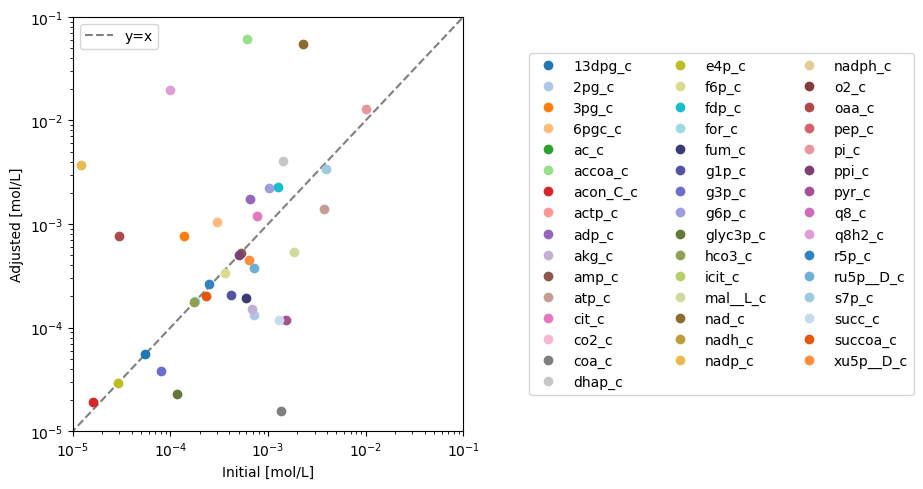

In [19]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [20]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations_extended.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
13dpg_c,0.000055,5.507545e-05
2pg_c,0.000725,1.312710e-04
3pg_c,0.000138,7.623383e-04
6pgc_c,0.000302,1.040886e-03
ac_c,0.000660,3.489012e+04
accoa_c,0.000606,6.123914e-02
acon_C_c,0.000016,1.893466e-05
actp_c,0.001070,4.984383e-01
adp_c,0.000656,1.755910e-03


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'Keq_EX_h2s_e', 'Keq_PPNCL2', 'Keq_SBTptspp', 'Keq_DHCURR', 'Keq_XYLI1', 'Keq_ASPtex', 'Keq_IPPMIb', 'Keq_CYSDtex', 'Keq_LPLIPAL1G141pp', 'Keq_INSH', 'Keq_EX_trp__L_e', 'Keq_EX_glyc_e', 'Keq_HACD6', 'Keq_AGM4PApp', 'Keq_ACHBS', 'Keq_EX_LalaDglu_e', 'Keq_S7PI', 'Keq_NADHXD', 'Keq_MNtex', 'Keq_2DGULRy', 'Keq_K2L4Aabctex', 'Keq_23PDE4pp', 'Keq_AGM3PA', 'Keq_SLNTabcpp', 'Keq_THDPS', 'Keq_PGPP181pp', 'Keq_EX_tre_e', 'Keq_ACOLIPAabctex', 'Keq_PDE4', 'Keq_SULFACabcpp', 'Keq_DHCIND', 'Keq_PLIPA1G181pp', 'Keq_RPNTPH', 'Keq_EX_dimp_e', 'Keq_DAGK120', 'Keq_HYD1pp', 'Keq_PLIPA2A180pp', 'Keq_LPLIPAL2ATE160', 'Keq_PLIPA2E181pp', 'Keq_ASNNpp', 'Keq_CADVtpp', 'Keq_EX_dxylnt_e', 'Keq_ASNN', 'Keq_AGPAT161', 'Keq_ARBTNtpp', 'Keq_26DAHtex', 'Keq_SERAT', 'Keq_LPLIPAL2A160', 'Keq_EX_metglcur_e', 'Keq_AACPS9', 'Keq_CBL1tonex', 'Keq_GNK', 'Keq_CTBTabcpp', 'Keq_UAGDP', 'Keq_LPLIPAL1A180pp', 'Keq_NTD8', 'Keq_PUNP5', 'Keq_APH120', 'Keq_CLPNS140

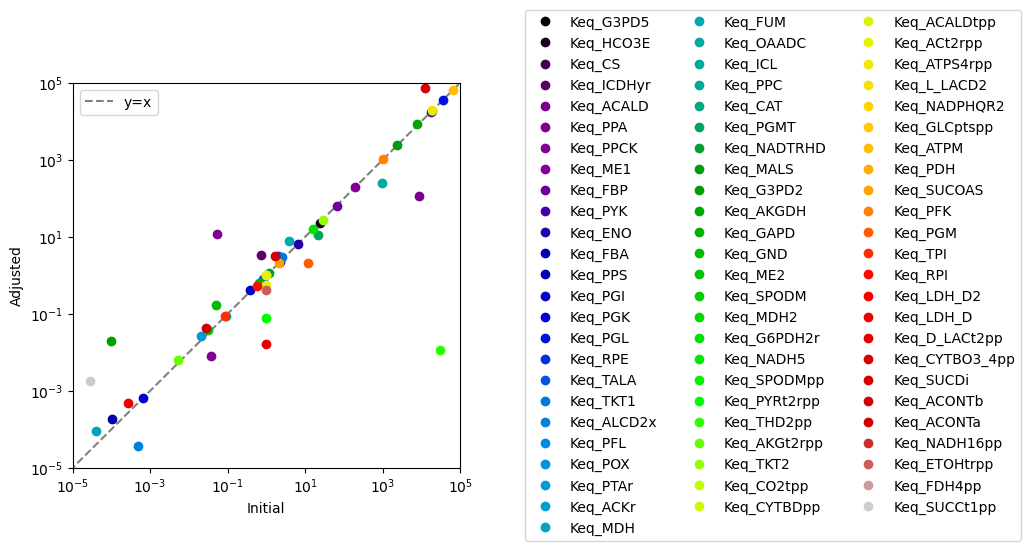

In [21]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [22]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants_extended.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_G3PD5,3.097852e+09,3.001950e+06
Keq_HCO3E,2.352797e+01,2.352797e+01
Keq_CS,4.465331e+06,4.465331e+06
Keq_ICDHyr,7.288431e-01,3.285634e+00
Keq_ACALD,8.884664e+03,1.129093e+02
...,...,...
Keq_ACONTa,2.777306e-02,4.330926e-02
Keq_NADH16pp,4.079883e+06,1.724759e+13
Keq_ETOHtrpp,1.000000e+00,4.279681e-01


In [23]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [24]:
from pprint import pprint
pprint(vars(mass_model.metabolites.co2_c))

{'_annotation': {'bigg.metabolite': ['co2'],
                 'biocyc': ['META:CARBON-DIOXIDE'],
                 'chebi': ['CHEBI:23011',
                           'CHEBI:3283',
                           'CHEBI:48829',
                           'CHEBI:16526',
                           'CHEBI:13283',
                           'CHEBI:13285',
                           'CHEBI:13284',
                           'CHEBI:13282'],
                 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/2ec3da94-5f50-4525-81b1-5607c5c7a3d3',
                              '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/05f60af4-0a3f-4ead-9a29-33bb0f123379'],
                 'hmdb': ['HMDB01967'],
                 'inchi_key': ['CURLTUGMZLYLDI-UHFFFAOYSA-N'],
                 'kegg.compound': ['C00011'],
                 'kegg.drug': ['D00004'],
                 'metanetx.chemical': ['MNXM13'],
                 'reactome.compound': ['29376',
                                       '56685

In [25]:
# #Set the metabolite for CO2 as a fixed metabolite using the "fixed" attribute (e.g., co2_c.fixed = True, etc.)
# mass_model.metabolites.co2_c.fixed = True
# mass_model.metabolites.co2_c.initial_condition = 0.001

In [26]:
n_models = 1

In [27]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
0,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.23341,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002


In [28]:
mass_model.fixed

{<MassMetabolite h_c at 0x1f939b043c8>: 1,
 <MassMetabolite h2o_c at 0x1f939b04548>: 1}

In [29]:
for x in mass_model.reactions:
    if x.steady_state_flux == 0:
        print(x.id)

LDH_D
D_LACt2pp
PYRt2rpp
ACALDtpp
ALCD2x
ETOHtrpp
OAADC
ME1
ME2
SUCCt1pp
AKGt2rpp
PGMT
G3PD2
CAT
SPODMpp
THD2pp
NADPHQR2
NADH5
LDH_D2
POX
G3PD5
L_LACD2
CYTBDpp


In [30]:
mass_model.metabolites.co2_c

MassMetabolite identifier,co2_c
Name,CO2 CO2
Memory address,0x01f939af3708
Formula,CO2
Compartment,c
Initial Condition,1576.9617169472906
In 12 reaction(s),"GND, POX, PPCK, PDH, ICDHyr, OAADC, AKGDH, ME2, CO2tpp, ME1, HCO3E, PPC"


In [31]:
mass_model.reactions.ICDHyr

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x01f939adc248
Subsystem,Citric Acid Cycle
Kinetic Reversibility,True
Stoichiometry,icit_c + nadp_c <=> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + CO2 CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,b1136
Bounds,"(-1000.0, 1000.0)"


In [32]:
mass_model.reactions[0]

Reaction identifier,GLCptspp
Name,D-glucose transport via PEP:Pyr PTS (periplasm)
Memory address,0x01f939b09bc8
Subsystem,"Transport, Inner Membrane"
Kinetic Reversibility,True
Stoichiometry,glc__D_p + pep_c <=> g6p_c + pyr_c D-Glucose + Phosphoenolpyruvate <=> D-Glucose 6-phosphate + Pyruvate
GPR,(b1621 and b2415 and b2417 and b2416) or (b1101 and b2416 and b2415 and b2417) or (b1819 and b2415 and b1818 and b1817 and b2416)
Bounds,"(0.0, 1000.0)"


### Balance network with pseudoreactions and calculate PERCs

In [33]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model CentralMetabolism_C0
Number of models in ensemble: 1


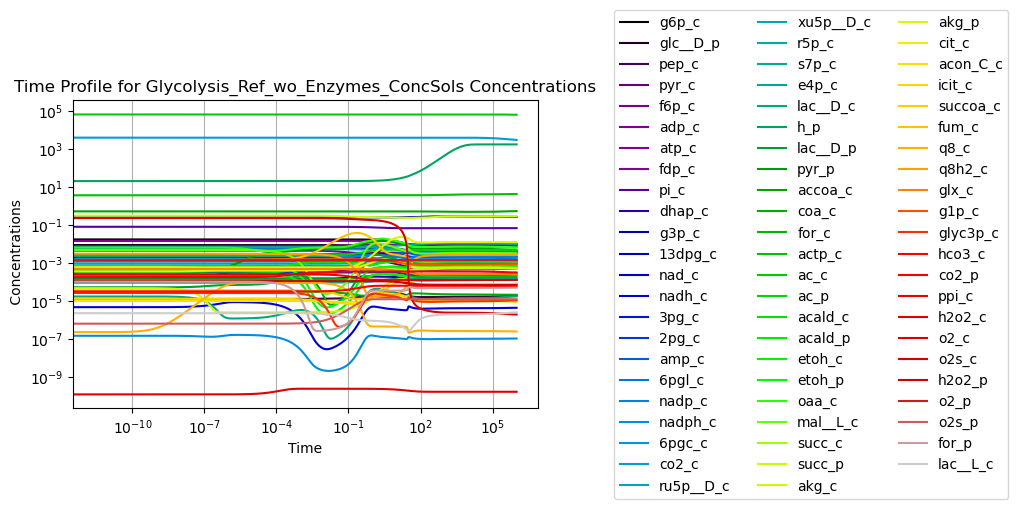

In [34]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

In [51]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.478402e+05,0.009513,0.003565,0.000019,0.000525,0.001096,0.003567,0.009257,0.009414,0.068497,0.004203,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.628319e+05,0.009515,0.003564,0.000019,0.000525,0.001097,0.003567,0.009257,0.009417,0.068494,0.004204,...,0.000319,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.778237e+05,0.009517,0.003563,0.000019,0.000525,0.001097,0.003567,0.009257,0.009419,0.068492,0.004204,...,0.000318,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003


In [52]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.478402e+05,0.002515,0.001323,0.002307,0.000200,0.002107,0.002111,0.004688,-0.004688,-0.004810,0.004810,...,7.781250e-06,7.781284e-06,5.759519e-06,7.080346e-05,6.954993e-03,3.455124e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868626e-04
9.628319e+05,0.002516,0.001323,0.002307,0.000200,0.002107,0.002112,0.004689,-0.004689,-0.004811,0.004811,...,7.768200e-06,7.768233e-06,5.760454e-06,7.073759e-05,6.948770e-03,3.455147e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868427e-04
9.778237e+05,0.002516,0.001324,0.002308,0.000200,0.002108,0.002112,0.004690,-0.004690,-0.004812,0.004812,...,7.755709e-06,7.755740e-06,5.761349e-06,7.067451e-05,6.942810e-03,3.455169e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868236e-04


# Checking reaction related to glucose

In [58]:
model = models_for_ensemble[0]

In [59]:
model.metabolites.glc__D_p

MassMetabolite identifier,glc__D_p
Name,D-Glucose
Memory address,0x01f93915cd88
Formula,C6H12O6
Compartment,p
Initial Condition,0.008899422406428256
In 2 reaction(s),"GLCptspp, SK_glc__D_p"


In [60]:
model.reactions.SK_glc__D_p

Reaction identifier,SK_glc__D_p
Name,D-Glucose sink
Memory address,0x01f939a67ac8
Subsystem,
Kinetic Reversibility,True
Stoichiometry,<=> glc__D_p <=> D-Glucose
GPR,
Bounds,"(-1000.0, 1000.0)"


In [61]:
flux_df['SK_glc__D_p']

Time
0.000000e+00    0.000000e+00
2.494698e-12    4.936393e-15
4.989396e-12    9.872786e-15
7.484093e-12    1.480918e-14
1.527795e-11    3.023019e-14
                    ...     
9.478402e+05    2.515467e-03
9.628319e+05    2.515896e-03
9.778237e+05    2.516306e-03
9.928155e+05    2.516699e-03
1.000000e+06    2.516880e-03
Name: SK_glc__D_p, Length: 3598, dtype: float64

In [62]:
model.reactions.GLCptspp

Reaction identifier,GLCptspp
Name,D-glucose transport via PEP:Pyr PTS (periplasm)
Memory address,0x01f939273c08
Subsystem,"Transport, Inner Membrane"
Kinetic Reversibility,True
Stoichiometry,glc__D_p + pep_c <=> g6p_c + pyr_c D-Glucose + Phosphoenolpyruvate <=> D-Glucose 6-phosphate + Pyruvate
GPR,(b1621 and b2415 and b2417 and b2416) or (b1101 and b2416 and b2415 and b2417) or (b1819 and b2415 and b1818 and b1817 and b2416)
Bounds,"(0.0, 1000.0)"


In [63]:
flux_df['GLCptspp']

Time
0.000000e+00    0.004196
2.494698e-12    0.004196
4.989396e-12    0.004196
7.484093e-12    0.004196
1.527795e-11    0.004196
                  ...   
9.478402e+05    0.002515
9.628319e+05    0.002516
9.778237e+05    0.002516
9.928155e+05    0.002517
1.000000e+06    0.002517
Name: GLCptspp, Length: 3598, dtype: float64

In [80]:
# unit is M/s
mass_rate_vol_spec = flux_df['SK_glc__D_p'].iloc[-1]*3600*180
mass_rate_gDW_spec = mass_rate_vol_spec/gDW_L_conversion_factor
print('The volume specific glucose sink rate is', np.round(mass_rate_vol_spec,2), 'grams per liter per hour (g/L/h).')
print('The biomass specific glucose sink rate is', np.round(mass_rate_gDW_spec,2), 'grams per gDW per hour (g/gDW/h).')

The volume specific glucose sink rate is 1630.94 grams per liter per hour (g/L/h).
The biomass specific glucose sink rate is 1.04 grams per gDW per hour (g/gDW/h).


In [81]:
# unit is M/s
mass_rate_vol_spec = flux_df['GLCptspp'].iloc[-1]*3600*180
mass_rate_gDW_spec = mass_rate_vol_spec/gDW_L_conversion_factor
print('The volume specific glucose uptake rate is', np.round(mass_rate_vol_spec,2), 'grams per liter per hour (g/L/h).')
print('The biomass specific glucose uptake rate is', np.round(mass_rate_gDW_spec,2), 'grams per gDW per hour (g/gDW/h).')

The volume specific glucose uptake rate is 1630.94 grams per liter per hour (g/L/h).
The biomass specific glucose uptake rate is 1.04 grams per gDW per hour (g/gDW/h).


In [138]:
model.boundary[0]

Reaction identifier,SK_g6p_c
Name,D-Glucose 6-phosphate sink
Memory address,0x01f9394aee48
Subsystem,
Kinetic Reversibility,True
Stoichiometry,g6p_c <=> D-Glucose 6-phosphate <=>
GPR,
Bounds,"(-1000.0, 1000.0)"


In [130]:
model.reactions.SK_glc__D_p.rate

kf_SK_glc__D_p*(glc__D_b - glc__D_p(t)/Keq_SK_glc__D_p)

In [131]:
model.reactions.SK_glc__D_p.Keq

1

In [132]:
model.reactions.SK_glc__D_p.kf

0.4715222750481437

In [139]:
model.boundary[1]

Reaction identifier,SK_glc__D_p
Name,D-Glucose sink
Memory address,0x01f939a67ac8
Subsystem,
Kinetic Reversibility,True
Stoichiometry,<=> glc__D_p <=> D-Glucose
GPR,
Bounds,"(-1000.0, 1000.0)"


In [140]:
print("Boundary Reaction and Values\n-----------------------------")
reaction = model.boundary[1]
boundary_met = reaction.boundary_metabolite
bc_value = model.boundary_conditions.get(boundary_met)
print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

Boundary Reaction and Values
-----------------------------
SK_glc__D_p:  <=> glc__D_p
glc__D_b: 0.008899422406428256



# Changing glucose boundary
From mass action to fixed rate. Fixed rate = rate at end of previous simulation

In [158]:
r_SK_glc__D_p = flux_df['SK_glc__D_p'].iloc[-1]
r_SK_glc__D_p

0.0025168795093415087

In [159]:
print("Boundary Reaction and Values\n-----------------------------")
reaction = model.boundary[1]
boundary_met = reaction.boundary_metabolite
bc_value = model.boundary_conditions.get(boundary_met)
print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

Boundary Reaction and Values
-----------------------------
SK_glc__D_p:  <=> glc__D_p
glc__D_b: 0.008899422406428256



In [160]:
# Set a custom rate for SK_glc__D_p to remove substrate concentration dependence
custom_parameter_dict = {"r_SK_glc__D_p": r_SK_glc__D_p}

model.add_custom_rate(
    model.reactions.SK_glc__D_p,
    custom_rate="r_SK_glc__D_p",
    custom_parameters=custom_parameter_dict)
print(model.reactions.SK_glc__D_p.rate)

r_SK_glc__D_p


In [161]:
model.reactions.SK_glc__D_p.all_parameter_ids

['kf_SK_glc__D_p', 'Keq_SK_glc__D_p', 'kr_SK_glc__D_p', 'v_SK_glc__D_p']

In [166]:
model.reactions.SK_glc__D_p.rate

r_SK_glc__D_p

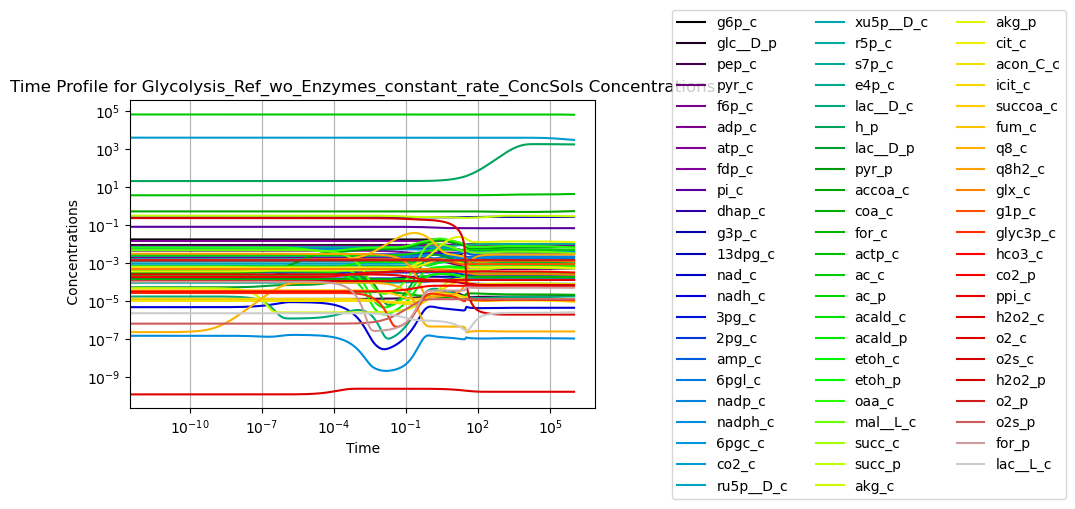

In [167]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

In [168]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.844199e+05,0.009520,0.003563,0.000019,0.000525,0.001097,0.003567,0.009257,0.009422,0.068491,0.004205,...,0.000318,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.908401e+05,0.009519,0.003563,0.000019,0.000525,0.001097,0.003567,0.009257,0.009422,0.068490,0.004206,...,0.000318,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003
9.952975e+05,0.009519,0.003562,0.000019,0.000525,0.001097,0.003567,0.009257,0.009422,0.068490,0.004206,...,0.000318,0.000130,1.703559e-10,0.000002,0.000070,0.001393,0.001438,1.259266e-05,0.000051,0.000003


In [169]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.844199e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004691,-0.004691,-0.004812,0.004812,...,7.737368e-06,7.737367e-06,5.761183e-06,7.066956e-05,6.942315e-03,3.455182e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867956e-04
9.908401e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004691,-0.004691,-0.004812,0.004812,...,7.737636e-06,7.737635e-06,5.761624e-06,7.064347e-05,6.939859e-03,3.455188e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867960e-04
9.952975e+05,0.002517,0.001324,0.002308,0.000200,0.002108,0.002112,0.004691,-0.004691,-0.004812,0.004812,...,7.737820e-06,7.737818e-06,5.761926e-06,7.062564e-05,6.938180e-03,3.455192e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.867963e-04


# Oscillation of the glucose availability

## 90 % of glucose uptake

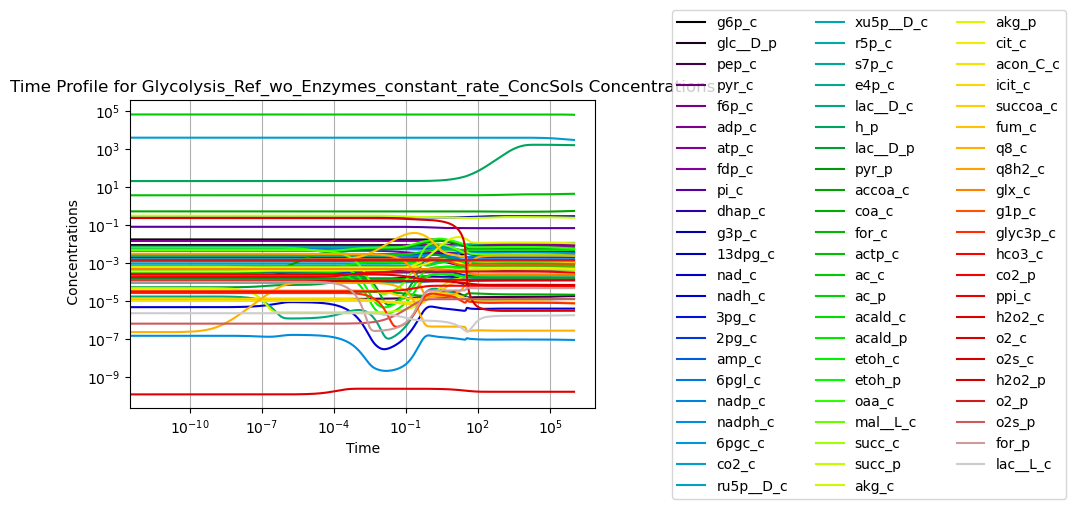

In [170]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"r_SK_glc__D_p":"r_SK_glc__D_p*0.9"}
)
conc_sol_orig.view_time_profile()

In [171]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.101687e+05,0.008288,0.003348,0.000018,0.000469,0.000990,0.003566,0.009266,0.008263,0.068977,0.003758,...,0.000319,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002
9.276786e+05,0.008288,0.003347,0.000018,0.000469,0.000990,0.003566,0.009266,0.008263,0.068975,0.003758,...,0.000318,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002
9.550852e+05,0.008287,0.003344,0.000019,0.000469,0.000990,0.003566,0.009266,0.008263,0.068972,0.003758,...,0.000318,0.000131,1.703559e-10,0.000003,0.000070,0.001393,0.001438,1.259266e-05,0.000048,0.000002


In [172]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.101687e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004342,-0.004342,-0.004490,0.004490,...,1.710608e-05,1.710607e-05,5.862071e-06,7.055476e-05,6.945078e-03,3.450125e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003696e-04
9.276786e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004342,-0.004342,-0.004490,0.004490,...,1.710846e-05,1.710845e-05,5.863497e-06,7.046425e-05,6.936557e-03,3.450144e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003728e-04
9.550852e+05,0.002265,0.001136,0.002085,0.000175,0.001909,0.001915,0.004342,-0.004342,-0.004490,0.004490,...,1.711198e-05,1.711198e-05,5.865594e-06,7.033123e-05,6.924034e-03,3.450173e-04,2.819638e-07,8.334590e-03,5.639277e-07,3.003777e-04


## 50 % of glucose uptake 

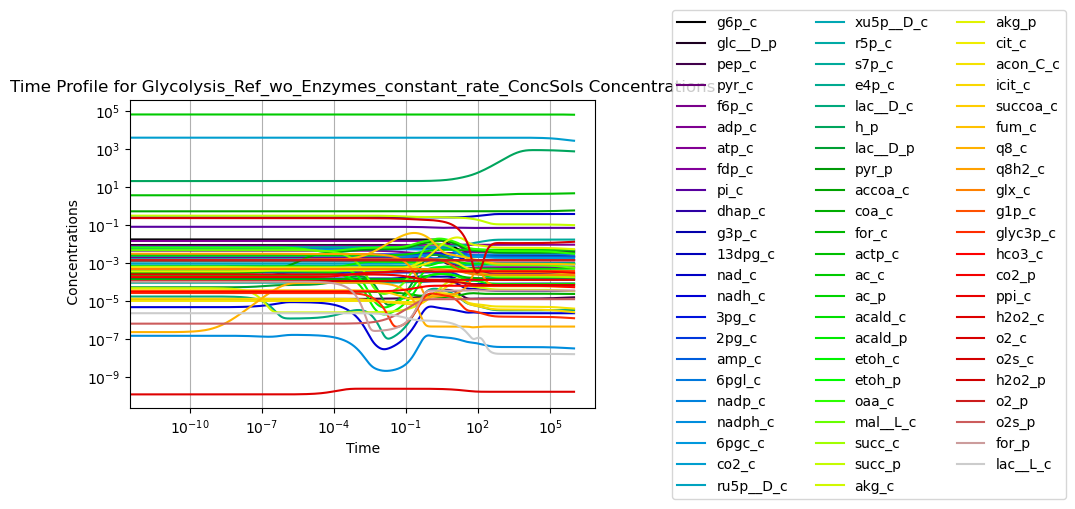

In [194]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"r_SK_glc__D_p":"r_SK_glc__D_p*0.5"}
)
conc_sol_orig.view_time_profile()

In [175]:
conc_df = conc_sol_orig.to_frame()
conc_df

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
2.494698e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
4.989396e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
7.484093e-12,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
1.527795e-11,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.233410,0.000114,0.001399,0.001444,6.471971e-07,0.000106,2.318767e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.413328e+05,0.004196,0.002180,0.000016,0.000278,0.000597,0.003574,0.009276,0.004589,0.070907,0.002210,...,0.000308,0.000131,1.703559e-10,0.013150,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.622206e-08
9.599880e+05,0.004196,0.002178,0.000016,0.000279,0.000597,0.003574,0.009276,0.004589,0.070904,0.002210,...,0.000308,0.000131,1.703559e-10,0.013160,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.621862e-08
9.786432e+05,0.004196,0.002177,0.000016,0.000279,0.000597,0.003574,0.009276,0.004589,0.070902,0.002210,...,0.000308,0.000131,1.703559e-10,0.013171,0.000070,0.001393,0.001438,1.259266e-05,0.000036,1.621534e-08


In [176]:
flux_df = flux_sol_orig.to_frame()
flux_df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.413328e+05,0.001258,0.000530,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003184,0.003184,...,8.027047e-05,8.027047e-05,6.129469e-06,6.427546e-05,6.418019e-03,3.429685e-04,2.819638e-07,7.865146e-03,5.639277e-07,3.646833e-04
9.599880e+05,0.001258,0.000529,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003184,0.003184,...,8.027112e-05,8.027112e-05,6.130900e-06,6.415038e-05,6.406240e-03,3.429709e-04,2.819638e-07,7.864761e-03,5.639277e-07,3.646838e-04
9.786432e+05,0.001258,0.000529,0.001258,0.000097,0.001161,0.001170,0.002933,-0.002933,-0.003184,0.003184,...,8.027174e-05,8.027174e-05,6.132263e-06,6.403131e-05,6.395027e-03,3.429733e-04,2.819638e-07,7.864393e-03,5.639277e-07,3.646842e-04


In [177]:
0.002517*0.5

0.0012585

## Oscillating around 50 % of glucose uptake 

In [201]:
sym.sympify("r_SK_glc__D_p*0.5*(sin(t/10)+1)")

0.5*r_SK_glc__D_p*(sin(t/10) + 1)

In [204]:
reference_model = model.copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes_constant_rate"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(
    reference_model,
    time=(0, tfinal),
    perturbations={"r_SK_glc__D_p":"r_SK_glc__D_p*0.5*(sin(t/10)+1)"}
)
conc_sol_orig.view_time_profile()

MassSimulationError: Critical simulation fail due to the following:
UnboundLocalError: local variable 'solutions' referenced before assignment